# Cenário 2: 16 qubits e 1 alvo

- Objetivo: construir e executar circuito quântico com o valor máximo possível ($|111...1\rangle$) e comparar o desempenho com o algorimto clássico.

Neste cenário, usamos:
- Número de qubits: $n = 16$
- Espaço de busca: $N = 2^n = 65.536$
- Número de alvos: $M = 1$
- Alvo: $|1111111111111111\rangle$

O número ideal de iterações de Grover é:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

## Implementação Automática do Algorimto de Grover

In [23]:
import time
import platform
import os
import shutil
import subprocess
from qiskit import transpile
from qiskit_aer import AerSimulator

# ----------------------------
# 1) Configuração do experimento
# ----------------------------
scenario_id = 2
target = "1111111111111111"              
shots = 1024
optimization_level = 1

In [24]:
import math
from qiskit import QuantumCircuit

# Função para construir o circuito de Grover com ancila
def build_grover_with_ancilla(target: str) -> tuple[QuantumCircuit, int]:
    """
    Constrói automaticamente um circuito de Grover (forma didática com 2 registradores):
    - Registrador de busca: n qubits (|x>)
    - Registrador ancila: 1 qubit (|y>)
    
    Oráculo implementado como U_f:
        U_f |x>|y> = |x>|y ⊕ f(x)>
    onde f(x)=1 se x == target, caso contrário 0.

    A ancila é preparada em |-> = (|0> - |1>)/sqrt(2) usando X seguido de H.
    Isso faz o "phase kickback", transformando o U_f em um efeito de fase no |x>.

    IMPORTANTE: este circuito mede apenas o registrador de busca (n bits clássicos).
    O alvo target[i] é associado ao qubit i (mesma ordem do seu input).

    Parameters
    ----------
    target : str
        String binária (ex.: "11", "10101", "11010101"), com tamanho n >= 1.

    Returns
    -------
    (QuantumCircuit, int)
        Circuito completo (com barreiras e medições) e o número de iterações k.
    """
    # ----------------------------
    # Validação do alvo
    # ----------------------------
    if not target or any(b not in "01" for b in target):
        raise ValueError("target deve ser uma string não-vazia contendo apenas '0' e '1'.")

    n = len(target)          # qubits de busca
    N = 2**n                 # espaço de busca
    M = 1                    # um único alvo
    k = int(math.floor((math.pi / 4) * math.sqrt(N / M)))  # iterações de Grover

    # ----------------------------
    # Índices de qubits
    # ----------------------------
    anc = n                  # ancila é o último qubit
    total_qubits = n + 1

    # Circuito: (n qubits busca + 1 ancila) e n bits clássicos
    qc = QuantumCircuit(total_qubits, n, name=f"Grover+Ancilla(target={target})")

    # ============================================================
    # 1) Preparação do estado inicial
    # ============================================================

    # (a) Busca em superposição uniforme: H em todos os qubits de busca
    qc.h(range(n))

    # (b) Ancila em |-> : X depois H (|0> -> |1> -> |->)
    qc.x(anc)
    qc.h(anc)

    qc.barrier()

    # ============================================================
    # Função interna: Oráculo U_f para "target" (flip na ancila)
    # ============================================================
    def apply_oracle_Uf(qc: QuantumCircuit):
        """
        Aplica U_f que faz flip na ancila somente quando |x> == |target>.
        Implementação:
        - X nos qubits onde target tem '0' para mapear |target> -> |11...1>
        - MCX(control=qubits de busca, target=ancila)
        - desfaz X
        """
        # Mapear |target> -> |11...1| aplicando X onde target tem 0
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

        # Flip na ancila se todos os qubits de busca forem 1
        if n == 1:
            qc.cx(0, anc)
        elif n == 2:
            qc.ccx(0, 1, anc)
        else:
            qc.mcx(list(range(n)), anc)

        # Desfazer mapeamento
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

    # ============================================================
    # Função interna: Difusor (inversão sobre a média) na busca
    # ============================================================
    def apply_diffuser(qc: QuantumCircuit):
        """
        Aplica o difusor apenas no registrador de busca (n qubits):
            D = H^{⊗n} X^{⊗n} MCZ X^{⊗n} H^{⊗n}
        onde MCZ marca |11...1> com fase -1.
        Implementação do MCZ:
            H no último qubit de busca
            MCX(controles = demais qubits de busca, alvo = último qubit de busca)
            H no último qubit de busca
        """
        # H e X em todos os qubits de busca
        qc.h(range(n))
        qc.x(range(n))

        # MCZ em |11...1> (somente no registrador de busca)
        if n == 1:
            # Para 1 qubit, difusor vira: H X Z X H
            qc.h(0)
            qc.z(0)
            qc.h(0)
        else:
            last = n - 1
            qc.h(last)

            if n == 2:
                # MCX com um controle = CX
                qc.cx(0, last)
            else:
                qc.mcx(list(range(n - 1)), last)

            qc.h(last)

        # desfazer X e H
        qc.x(range(n))
        qc.h(range(n))

    # ============================================================
    # 2) Iterações de Grover: (oráculo + difusor) repetidas k vezes
    # ============================================================
    for _ in range(k):
        apply_oracle_Uf(qc)
        qc.barrier()
        apply_diffuser(qc)
        qc.barrier()

    # ============================================================
    # 3) Medição: medir apenas registrador de busca
    # ============================================================
    qc.measure(range(n), range(n))

    return qc, k

# ----------------------------
# Exemplos rápidos de uso
# ----------------------------
# qc2, k2 = build_grover_with_ancilla("11")
# print("k =", k2)
# print(qc2.draw(output="text", fold=-1))

# qc5, k5 = build_grover_with_ancilla("10101")
# print("k =", k5)
# print(qc5.draw(output="text", fold=200))

In [25]:
# ----------------------------
# 2) Montar circuito (reutiliza sua função)
# ----------------------------
qc, k = build_grover_with_ancilla(target)

n = len(target)
N = 2**n
M = 1
anc = n  # índice da ancila (último qubit), só para referência

print(f"Cenário {scenario_id} -> n={n}, N={N}, M={M}, alvo=|{target}>, shots={shots}, k={k}")
print(qc.draw(output="text", fold=-1))

Cenário 2 -> n=16, N=65536, M=1, alvo=|1111111111111111>, shots=1024, k=201
      ┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░       ░ ┌───┐┌───┐          ┌──

In [26]:
# ----------------------------
# 3) Executar o circuito no simulador (Aer)
# ----------------------------
import time
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Backend simulador (sem ruído, CPU)
backend = AerSimulator()

# (opcional) para reprodutibilidade
seed_simulator = 123
seed_transpiler = 123

# 1) Transpilar (adaptar o circuito ao backend) e medir tempo
t0 = time.perf_counter()
tqc = transpile(qc, backend=backend, optimization_level=1, seed_transpiler=seed_transpiler)
t1 = time.perf_counter()
t_transpile = t1 - t0

# 2) Executar e medir tempo
t2 = time.perf_counter()
job = backend.run(tqc, shots=shots, seed_simulator=seed_simulator)
result = job.result()
t3 = time.perf_counter()
t_run = t3 - t2

# 3) Obter contagens de medição
counts = result.get_counts()

# 4) Indicadores simples do resultado
hits_target = counts.get(target, 0)
p_target = hits_target / shots

top_state, top_count = max(counts.items(), key=lambda kv: kv[1])

print("\n" + "=" * 65)
print("EXECUÇÃO (SIMULADOR)")
print("-" * 65)
print(f"Tempo de transpile: {t_transpile:.8f} s")
print(f"Tempo de execução (run): {t_run:.8f} s")
print(f"Tempo total (aprox): {t_transpile + t_run:.8f} s")
print("-" * 65)
print(f"P(|{target}>): {p_target:.4f}  ({hits_target}/{shots})")
print(f"Estado mais frequente: |{top_state}> com {top_count}/{shots}")
print(f"Counts: {counts}")
print("=" * 65)


EXECUÇÃO (SIMULADOR)
-----------------------------------------------------------------
Tempo de transpile: 0.08770787 s
Tempo de execução (run): 0.60162513 s
Tempo total (aprox): 0.68933300 s
-----------------------------------------------------------------
P(|1111111111111111>): 1.0000  (1024/1024)
Estado mais frequente: |1111111111111111> com 1024/1024
Counts: {'1111111111111111': 1024}


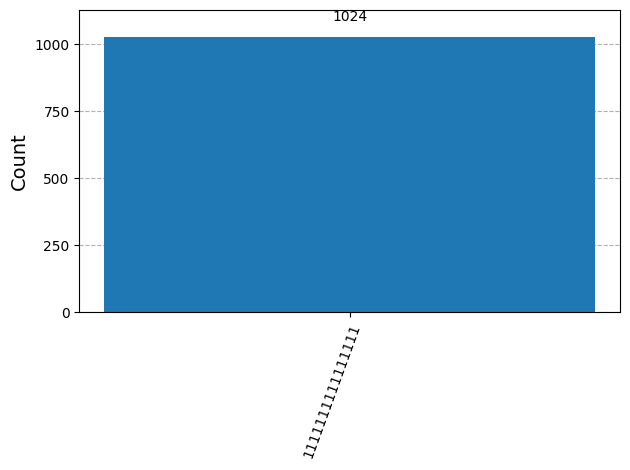

In [27]:
# 5) Histograma
plot_histogram(counts)